# Debugging:
## This script imports C and Python HDF output for comparison

In [192]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Labels and timestamps

In [193]:
#####################################################
#
# Time labels for C and Python
#

t_label = '001'
label = t_label + '_' + 'ic'

label = t_label + '_' + 'before_advect'
label = t_label + '_' + 'after_advect'
label = t_label + '_' + 'after_ebnaexp'
label = t_label + '_' + 'after_ebnaimp'
# label = t_label + '_' + 'after_half_step'
# label = t_label + '_' + 'after_efna'
# label = t_label + '_' + 'after_full_advect'
# label = t_label + '_' + 'after_full_ebnaexp'
label = t_label + '_' + 'after_full_step'

# t_label = '038'
# time = t_label + '_' + 'after_full_step'
time = label
# #
#####################################################

#####################################################
#
# C-output folder names
#
base_suffix = '_acoustic_wave_high/'
# base_suffix = '_internal_long_wave/'
# base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
# base_suffix = '_travelling_vortex_3d_48_with_initial_projection/'
#
#####################################################
#
# and its filename
#
py_filename = "output_acoustic_wave_high_low_mach_gravity_comp.h5"
# py_filename = "output_internal_long_wave_low_mach_gravity_comp.h5"
# py_filename = "output_travelling_vortex_3d_48_low_mach_gravity_comp.h5"

#####################################################

figsize_tuple = (12,3)

## Converter

Converts all hdf4 output of RKLM C-code to hdf5.

In [194]:
base_folder_name = "output"

base_path = base_folder_name + base_suffix
folder_comp = "low_Mach_gravity_comp/"
folder_psinc = "low_Mach_gravity_psinc/"

# Manually list the folder names for each output
directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
directories += ['rhou', 'rhov', 'rhow', 'rhs']
directories += ['buoy']

# And manually list the file names.
filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
filenames += ['rhou', 'rhov', 'rhow', 'rhs']
filenames += ['buoy']

# specify the format extensions for input and output of converter
hdf_format = '.'+ 'hdf'
h5_format = '.' + 'h5'

if time == '001' or time == '005':
    directories += ['flux_x', 'flux_y']
    filenames += ['rhoYu', 'rhoYv']

if time == t_label + '_' + 'after_ebnaimp':
    directories += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    filenames += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']

string_hdf = '_' + time + hdf_format
string_h5 = '_' + time + h5_format
full_path = base_path + folder_comp

lst_hdf = []
lst_h5 = []

# build list of paths from parameters specified above.
i = 0
for directory in directories:
    lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
    lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
    i += 1 

# print the list of paths
for path in lst_hdf:
    print(path)

# now, convert the arrays specified in the list of paths
for item in lst_hdf:
    p = subprocess.call(["./h4toh5convert", item])

output_acoustic_wave_high/low_Mach_gravity_comp/S/S_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/T/T_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/Y/Y_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/buoy/buoy_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dT/dT_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dY/dY_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dp2_c/dp2_c_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dp2_nodes/dp2_n_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dpdim/dpdim_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/drhoY/drhoY_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/p/p_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/p2_c/p2_c_001_after_full_step.hdf
output_acoustic_wave_high/low_Mach_g

## Import C hdf5 output

Import the test case arrays from the c-output.

In [195]:
# manually specific folder names
test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
# test_cases_folders += ['debug', 'debug', 'debug']

test_cases_folders += ['rhs']
test_cases_folders += ['buoy']

# and filenames
test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']

test_cases_names += ['rhs']
test_cases_names += ['buoy']

if time == '001' or time == '005':
    test_cases_folders += ['flux_x','flux_y']
    test_cases_names += ['rhoYu', 'rhoYv']

if time == t_label + '_' + 'after_ebnaimp':
    test_cases_folders += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    test_cases_names += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']
    
test_cases_folders = np.char.array(test_cases_folders)
test_cases_names = np.char.array(test_cases_names)
    
# build paths from folder names and filenames
test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

# define empty class as a holder for all the C-hdf5 output.
class c_output(object):
    def __init__(self):
        None
        
    def c_out(self):
        for key,value in vars(self).items():
            setattr(self,key,value['Data-Set-2'])
            
# get an instance of an empty class to populate it with the C-HDF output as attributes
c = c_output()

# populate the class with the C-HDF output as attributes
i = 0
for path in test_cases_paths:
    setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
    i += 1
    
    
# run the method to extract array from HDF objects
c.c_out()

## Import the Python output

In [196]:
# specify directory where the python hdf5 output is.
# py_directory = "../RKLM_Python/"
py_directory = "../"

py_path = py_directory + py_filename

# helper function to extract array from hdf file by its name and timestep

label = '_' + label
def py_out(py_dataset,time=label):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

## Helper diagnostic functions

In [197]:
# print an array
def p(obj):
    print(obj)
    
# visualise an array
def v(obj):
    plt.imshow(obj)
    plt.colorbar()
    plt.show()
    
# plot a slice of the array, default is x = 0 for all y (slice at origin)
def s(obj,slc=(slice(None))):
    plt.plot(obj['Data-Set-2'][slc])
    plt.show()
    
# plot the difference between the C and Python outputs
def diff(obj_c, obj_py, title, option = None):
#     obj_c = obj_c[2:-2,2:-2]
#     obj_c -= obj_c.mean()
#     obj_py = obj_py[2:-2,2:-2]
#     obj_py -= obj_py.mean()
#     
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    if option == None:
        max_norm = np.abs(obj_c - obj_py)
    else:
        max_norm = (obj_c - obj_py)
    
    max_diff = np.max(max_norm)
    
    fig, ax = plt.subplots(ncols=3, figsize=figsize_tuple)
    # plot c array
    im_c = ax[0].pcolor(obj_c, label="c")
    fig.colorbar(im_c,ax=ax[0])
    ax[0].set_title("c")
    ax[0].set_aspect('auto')
    
    # plot python array
    im_py = ax[1].pcolor(obj_py, label="py")
    fig.colorbar(im_py,ax=ax[1])
    ax[1].set_title("py")
    ax[1].set_aspect('auto')

    # plot the difference between the two
    im_diff = ax[2].pcolor(max_norm, label="diff")
    fig.colorbar(im_diff,ax=ax[2])
    ax[2].set_title("diff")
    ax[2].set_aspect('auto')
    
    # calculate the max difference relative to the C-output for non-zero values.
    if c_range == 0.0:
        rel_diff = 0.0
    else:
        rel_diff = max_diff/c_range
        
    print("comparison = %s,\nc_range = %e, py_range = %e, \nmax diff = %e, rel. diff = %e," %(title, c_range, py_range, max_diff, rel_diff))
    plt.tight_layout(h_pad=1)
    plt.show()
    print("################################################## \n")

comparison = p2_nodes,
c_range = 2.026909e+04, py_range = 2.026909e+04, 
max diff = 3.051758e-05, rel. diff = 1.505622e-09,


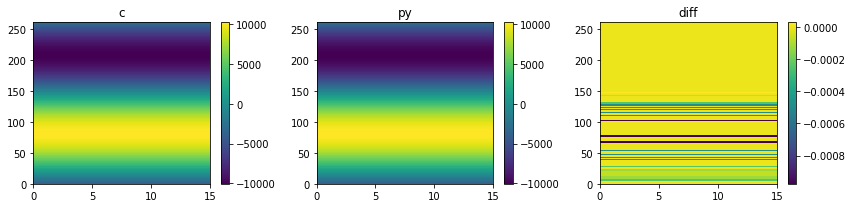

################################################## 

comparison = buoy,
c_range = 0.000000e+00, py_range = 0.000000e+00, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


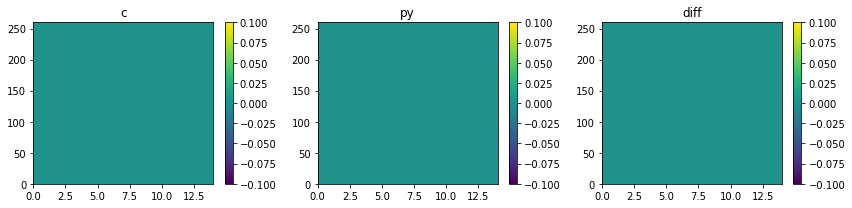

################################################## 

comparison = rho,
c_range = 2.000739e-01, py_range = 2.000739e-01, 
max diff = 5.960464e-08, rel. diff = 2.979131e-07,


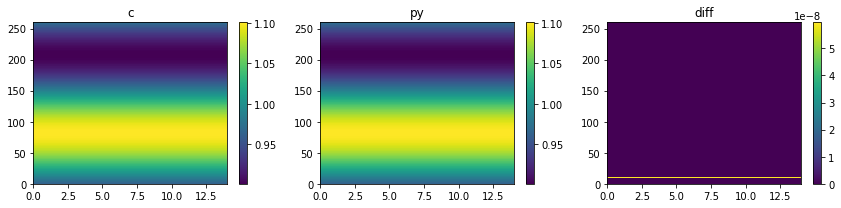

################################################## 

comparison = rhoY,
c_range = 2.000739e-01, py_range = 2.000739e-01, 
max diff = 5.960464e-08, rel. diff = 2.979131e-07,


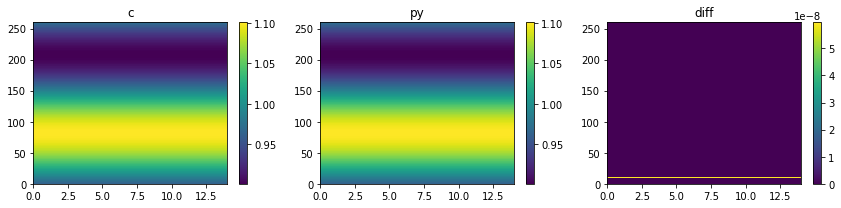

################################################## 

comparison = rhou,
c_range = 9.037534e+01, py_range = 9.037534e+01, 
max diff = 3.814697e-06, rel. diff = 4.220950e-08,


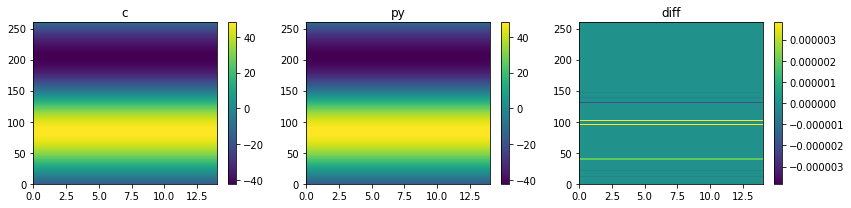

################################################## 

comparison = rhov,
c_range = 1.778493e-14, py_range = 2.711013e-14, 
max diff = 1.485208e-14, rel. diff = 8.350931e-01,


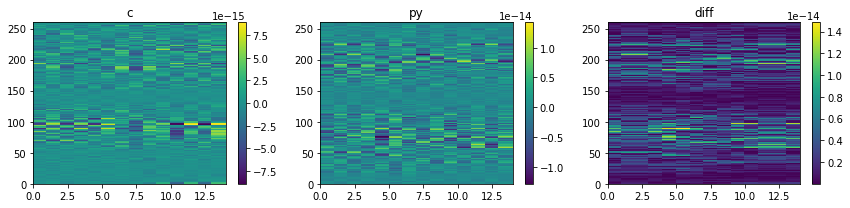

################################################## 

comparison = vortz,
c_range = 4.504915e-13, py_range = 1.019813e-12, 
max diff = 6.185969e-13, rel. diff = 1.373160e+00,


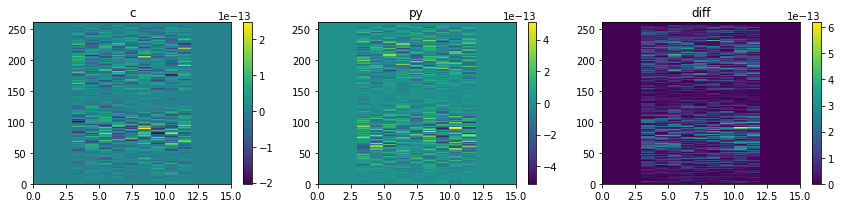

################################################## 

comparison = Y,
c_range = 0.000000e+00, py_range = 0.000000e+00, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


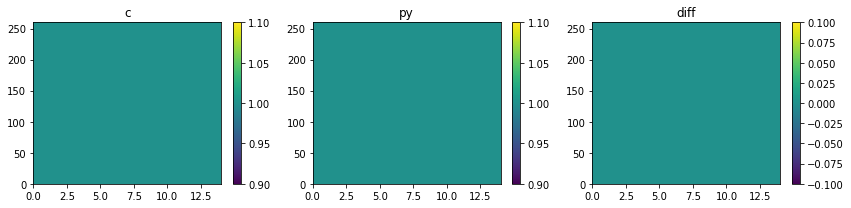

################################################## 



In [198]:
# open the Python HDF file
pyfile = h5py.File(py_path, 'r')

# make comparisons for the arrays.
# Arguments: C-array (class attribute), Python-array (numpy array), and a title.
# PPP = np.copy(py_out('dp2_nodes'))
# PPP[:,-4:-2] = py_out('dp2_nodes')[:,2:4][::-1]

# diff(c.pnew, PPP, 'dp2_nodes')

inner = (slice(2,-2),slice(2,-2))
iwp = (slice(2,-2),slice(2,-2))
iwp_e = (slice(2,-2),slice(2,-2))
iwp_n = (slice(2,-3),slice(2,-3))
# iwp = (slice(None),slice(None))
if time == t_label + '_' + 'after_ebnaimp':
#     diff(c.hcenter, py_out('hcenter'), 'hcenter')
#     diff(c.wplusx[iwp], py_out('wplusx')[iwp_n], 'wplusx')
#     diff(c.wplusy[iwp], py_out('wplusy')[iwp_n], 'wplusy')
    diff(c.pnew[inner], py_out('p2_full')[inner], 'p2_full', option='na')
#     diff(c.rhs_nodes, py_out('rhs_nodes'), 'rhs_nodes')
#     diff(c.p2_initial, py_out('p2_initial'), 'p2_initial')
    
if time == '001' or time == '005':
    diff(c.flux_x, py_out('rhoYu').T, 'rhoYu')
    diff(c.flux_y, py_out('rhoYv').T, 'rhoYv')
    
# print(py_out('lap_test'))
# fig = plt.figure(figsize=(5,5))
# plt.pcolor(py_out('lap_test'))
# plt.colorbar()
# plt.show()

# diff(c.pnew,py_out('dp2_nodes'),'dp2_nodes')
# diff(c.rhs, py_out('rhs'), 'rhs')
diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes', option='na')
diff(c.buoy,py_out('X'),'buoy')
# diff(c.dp2_c,py_out('dp2_cells'),'dp2_cells')
# diff(c.p2_c,py_out('p2_cells'),'p2_cells')

diff(c.rho,py_out('rho'),'rho')
# # diff(c.rhoe,py_out('rhoe'),'rhoe')
diff(c.rhoY,py_out('rhoY'),'rhoY')

diff(c.rhou,py_out('rhou'),'rhou', option='na')
# # print(np.argmax(np.abs(c.rhou - py_out('rhou'))))
diff(c.rhov,py_out('rhov'),'rhov')
# diff(c.rhow,py_out('rhow'),'rhow')

# diff(c.u, py_out('u'), 'u')
# diff(c.p, py_out('p'), 'p')
# diff(c.dpdim, py_out('dpdim'), 'dpdim')
diff(c.vortz, py_out('vortz'), 'vortz')

# diff(c.T, py_out('T'), 'T')
# diff(c.dT, py_out('dT'), 'dT')

diff(c.Y, py_out('Y'), 'Y')
# diff(c.dY, py_out('dY'), 'dY')

# print(c.hcenter[:][2:-2,2:-2])
# print(py_out('hcenter')[2:-2,2:-2])

# print(np.where(py_out('p2_initial')[inner] == 0.)[0])

# if time == '004':
#     idx = 0
#     fig = plt.figure(figsize=(9,9))
#     plt.plot(py_out('p2_full')[inner][:,idx], 'r')
#     plt.plot(c.pnew[inner][:,7])
#     plt.xlabel('p2_full')
#     plt.ylabel('error')
#     plt.show()

#     fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('p2_full') - c.pnew)[inner][:,idx])
#     plt.xlabel('diff')
#     plt.ylabel('error')
#     plt.show()
    
#     fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('p2_initial')[inner])[:,7])
#     plt.xlabel('p2_initial')
#     plt.ylabel('value')
#     plt.show()
    
#     print(py_out('p2_initial')[inner][2,:][:10])
    
if time == '002':
    idx = 1
    fig = plt.figure(figsize=(9,9))
    plt.plot(py_out('rhou')[:,idx],'r', label='python-output')
    plt.plot(c.rhou[:,idx],'k', label='c-output')
    plt.title('rhou, sliced at idx %i' %idx )
    plt.ylabel('rhou')
    plt.xlabel('x')
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('rhou') - c.rhou)[:,idx])
    plt.title('difference in rhou outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
    
if time == '007':
    idx = 10
    fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx])
#     plt.plot(py_out('rhou')[:,idx][:2],'r', label='python-output')
#     plt.plot(c.rhou[:,idx][:2],'k', label='c-output')
    plt.plot((py_out('rhou') - c.rhou)[:,idx][:5])
    plt.title('difference in rhou outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
if time == '005':
    idx = 3
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('rhoYu').T - c.flux_x)[:,idx])
    plt.title('difference in rhoYu outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
if time == '003':
    idx = 100
    fig = plt.figure(figsize=(9,9))
    plt.plot(py_out('rhov')[idx,:], '-ro',label='python')
    plt.plot(c.rhov[idx,:], '-bo',label='c')
    plt.title("rhov sliced at the 100th row (i.e. at x = 100)")
    plt.xlabel("y")
    plt.ylabel("rhov")
    plt.legend()
    plt.show()
    
# if time == t_label + '_' + 'after_half_step':
# idx = 7
# fig = plt.figure(figsize=(15,9))
# # plt.plot(py_out('rhou')[:,idx],'r', label='python-output')
# # plt.plot(c.rhou[:,idx],'k', label='c-output')
# plt.plot((py_out('rhou') - c.rhou)[:,idx], label='diff profile')
# plt.title('difference in rhou outputs, sliced at idx %i' %idx )
# plt.xlabel('diff')
# plt.ylabel('error')
# plt.legend()
# plt.show()

# idx = 12
# fig = plt.figure(figsize=(15,9))
# # plt.plot(py_out('p2_nodes')[:,idx],'r', label='python-output')
# # plt.plot(c.p2_nodes[:,idx],'k', label='c-output')
# plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx], label='diff profile')
# plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
# plt.xlabel('diff')
# plt.ylabel('error')
# plt.legend()
# plt.show()

# idx = 100
# fig = plt.figure(figsize=(15,9))
# plt.plot(py_out('p2_full')[inner][idx,:],'r', label='python-output')
# plt.plot(c.pnew[inner][idx,:],'k', label='c-output')
# # plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx], label='diff profile')
# plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
# plt.xlabel('diff')
# plt.ylabel('error')
# plt.legend()
# plt.show()

pyfile.close()

In [199]:
pyfile.close()

In [200]:
print((False and False))

False


In [201]:
from scipy import signal

x_periodic = 1
y_periodic = 0

igx = igy = 2

idx_e = (slice(igx - x_periodic,-igx + x_periodic - 1),slice(igy - y_periodic, -igy + y_periodic - 1))

AA = np.arange(88).reshape(11,8)
print(AA)
print(AA[idx_e])

kernel = [[1.,1.],[1.,1.]]

AB = signal.convolve2d(AA[idx_e],kernel,mode='full')
print(AB)



[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]
 [64 65 66 67 68 69 70 71]
 [72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87]]
[[10 11 12]
 [18 19 20]
 [26 27 28]
 [34 35 36]
 [42 43 44]
 [50 51 52]
 [58 59 60]
 [66 67 68]]
[[ 10.  21.  23.  12.]
 [ 28.  58.  62.  32.]
 [ 44.  90.  94.  48.]
 [ 60. 122. 126.  64.]
 [ 76. 154. 158.  80.]
 [ 92. 186. 190.  96.]
 [108. 218. 222. 112.]
 [124. 250. 254. 128.]
 [ 66. 133. 135.  68.]]
